In [1]:
%cd /home/dongmin/23FW-NCG/jeongganbo-omr
%load_ext autoreload
%autoreload 2

/home/dongmin/23FW-NCG/jeongganbo-omr


In [2]:
import glob
import cv2
import numpy as np
from data_utils import JeongganboReader
import matplotlib.pyplot as plt

from exp_utils import read_jngb, make_jng_gen_and_list, JngMatcher, COLOR_DICT

# Load ext files and paths

**Daegeum**
* YeoMinRock score (p17~36)
* pitch names
* notations

In [3]:
%%capture
reader = JeongganboReader()

ymr_infos = {
  "name": 'daegeum',
  "start": 17, # page 17 ~ 36
  "num_page": 20
}

ymr = read_jngb(reader, ymr_infos)

_, jng_list = make_jng_gen_and_list(reader, ymr)

pattern_path_base = 'test/daegeum/'
pattern_path_sub = ['notations/', 'pitches/']
pattern_ext = '.png'

pattern_paths = { 
  subpath[:-1]: {
    path.replace(f'{pattern_path_base}{subpath}', '').replace(pattern_ext, ''): path \
    for path in glob.glob(f'{pattern_path_base}{subpath}*{pattern_ext}')
  } for subpath in pattern_path_sub 
}

print([ name for name in pattern_paths['notations'].keys() ])
print([ name for name in pattern_paths['pitches'].keys() ])

# **CONSTANTS**

In [5]:
THRESHOLD = 0.5
MATCH_MODE = cv2.TM_CCOEFF_NORMED
PTRN_SIZE = 50

JNG_INDICES = [0, 4, 43, 161, 286, 289]

PTRN_TEST_ORDER = ['hwang_uu', 'hwang_u', 'hwang', 'joong_u', 'joong', 'lim_u', 'lim_d', 'lim', 'mu_d', 'mu_u', 'mu', 'nam_u', 'nam_d', 'nam', 'tae_u', 'tae']

PNAME_SURFIXS = ['uu, u, d, dd']

PTRN_IMG_DICT = { name: cv2.imread(pattern_paths['pitches'][name]) for name in PTRN_TEST_ORDER }

jng_matcher = JngMatcher(PTRN_SIZE, THRESHOLD, MATCH_MODE)

In [6]:
target_jng_list = jng_list

# extracting exact char bbox with entity dectection
1. sum all bbox from template matching
1. slice summed bbox from the image
1. run entity detection inside sliced image
1. return exact bbox

**known edge cases**
* 289th jng's tae_u
* 286th jng's lim

## step by step logic

### group bboxs from template matching result

total bbox 9
[(26, 1, 76, 51, 0.53146946, 'lim_u'), (29, 1, 79, 51, 0.50202304, 'lim'), (29, 1, 79, 51, 0.52597374, 'joong')]


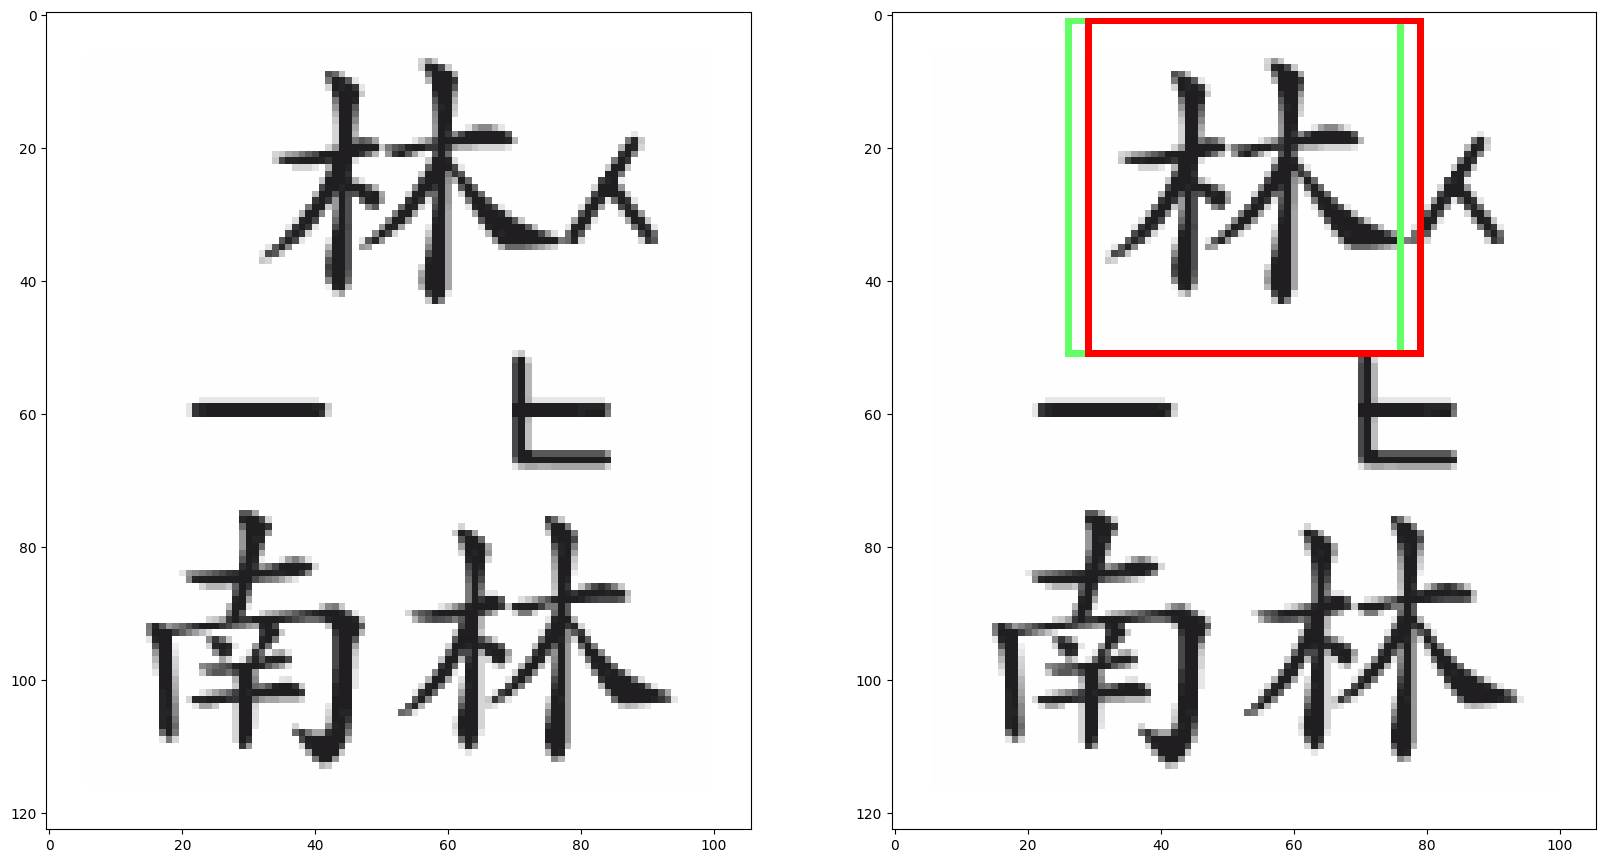

In [54]:
target_jng_idx = 286

jng_img = jng_matcher.remove_border_add_padding(target_jng_list[target_jng_idx][0])

jng_bbox_list = []
bbox_total = 0

for ptrn_key, ptrn_img in PTRN_IMG_DICT.items():
  xCords, yCords, match_result = jng_matcher.match(jng_img, ptrn_img)
  bboxs_w_confi = [(x, y, match_result[y][x]) for x, y in zip(xCords, yCords)]
  bboxs_merged_w_confi = jng_matcher.merge_bboxs(bboxs_w_confi)
  
  bbox_total += len(bboxs_merged_w_confi) # for debugging
  
  if(len(bboxs_merged_w_confi) > 0):
    jng_bbox_list += [bbox + (ptrn_key,) for bbox in bboxs_merged_w_confi]

print('total bbox', bbox_total)

jng_bbox_groups = jng_matcher.group_bboxs(jng_bbox_list, min_ratio=0.6)

group_idx = 0

print(jng_bbox_groups[group_idx])

jng_img_bbox_grouped = jng_img.copy()

for idx, box in enumerate(jng_bbox_groups[group_idx]):
  tl_x, tl_y, br_x, br_y, confi, pname  = box
  color = COLOR_DICT[pname]
  
  cv2.rectangle(jng_img_bbox_grouped, (tl_x, tl_y), (br_x, br_y), color, 1)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_bbox_grouped)

### sum bboxs in the group and slice

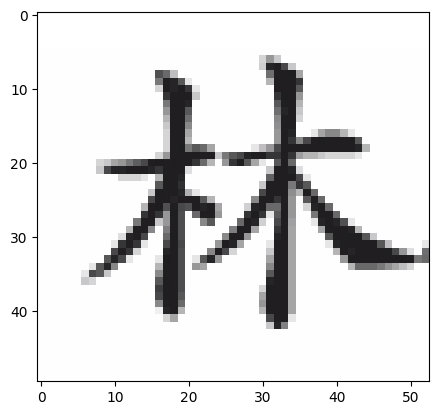

In [56]:
# tl_x, tl_y, br_x, br_y, confi, label
target_group_idx = 0

slice_tl_x, slice_tl_y, slice_br_x, slice_br_y = jng_matcher.get_bbox_of_bbox_group(jng_bbox_groups[target_group_idx], jng_img)
jng_img_group_coxt = jng_img.copy()[slice_tl_y:slice_br_y, slice_tl_x:slice_br_x]

plt.imshow(jng_img_group_coxt)

### extract contours and merge from sliced img

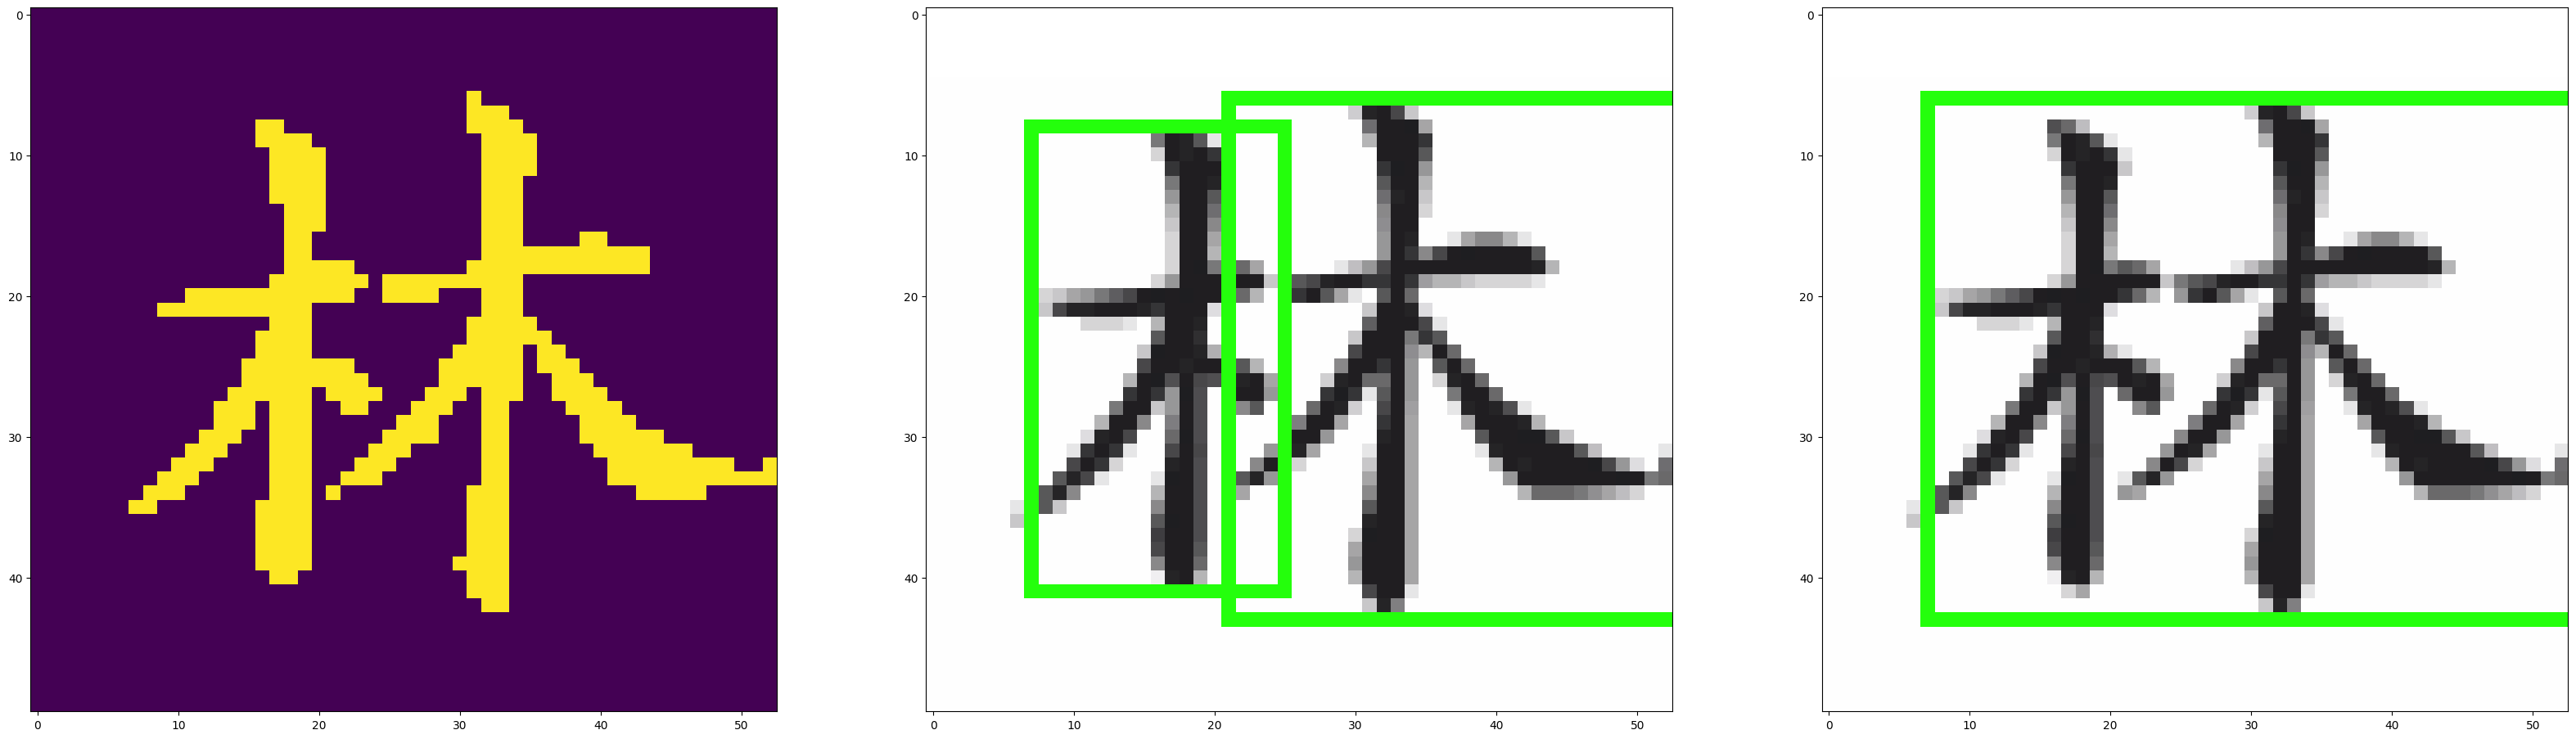

In [75]:
jng_char_exact_bbox, jng_img_sliced_thresh, jng_char_conts = jng_matcher.find_contour_bbox(jng_img_group_coxt, filter_edge_content=True)

jng_img_sliced_bboxs = jng_img_group_coxt.copy()
for cont in jng_char_conts:
  cv2.rectangle(jng_img_sliced_bboxs, cont[:2], cont[2:], (36,255,12), 1)  

jng_img_sliced_bbox = jng_img_group_coxt.copy()
cv2.rectangle(jng_img_sliced_bbox, jng_char_exact_bbox[:2], jng_char_exact_bbox[2:], (36,255,12), 1)

plt.figure(figsize=(40, 40))

plt.subplot(1, 3, 1)
plt.imshow(jng_img_sliced_thresh)

plt.subplot(1, 3, 2)
plt.imshow(jng_img_sliced_bboxs)

plt.subplot(1, 3, 3)
plt.imshow(jng_img_sliced_bbox)

## full logic

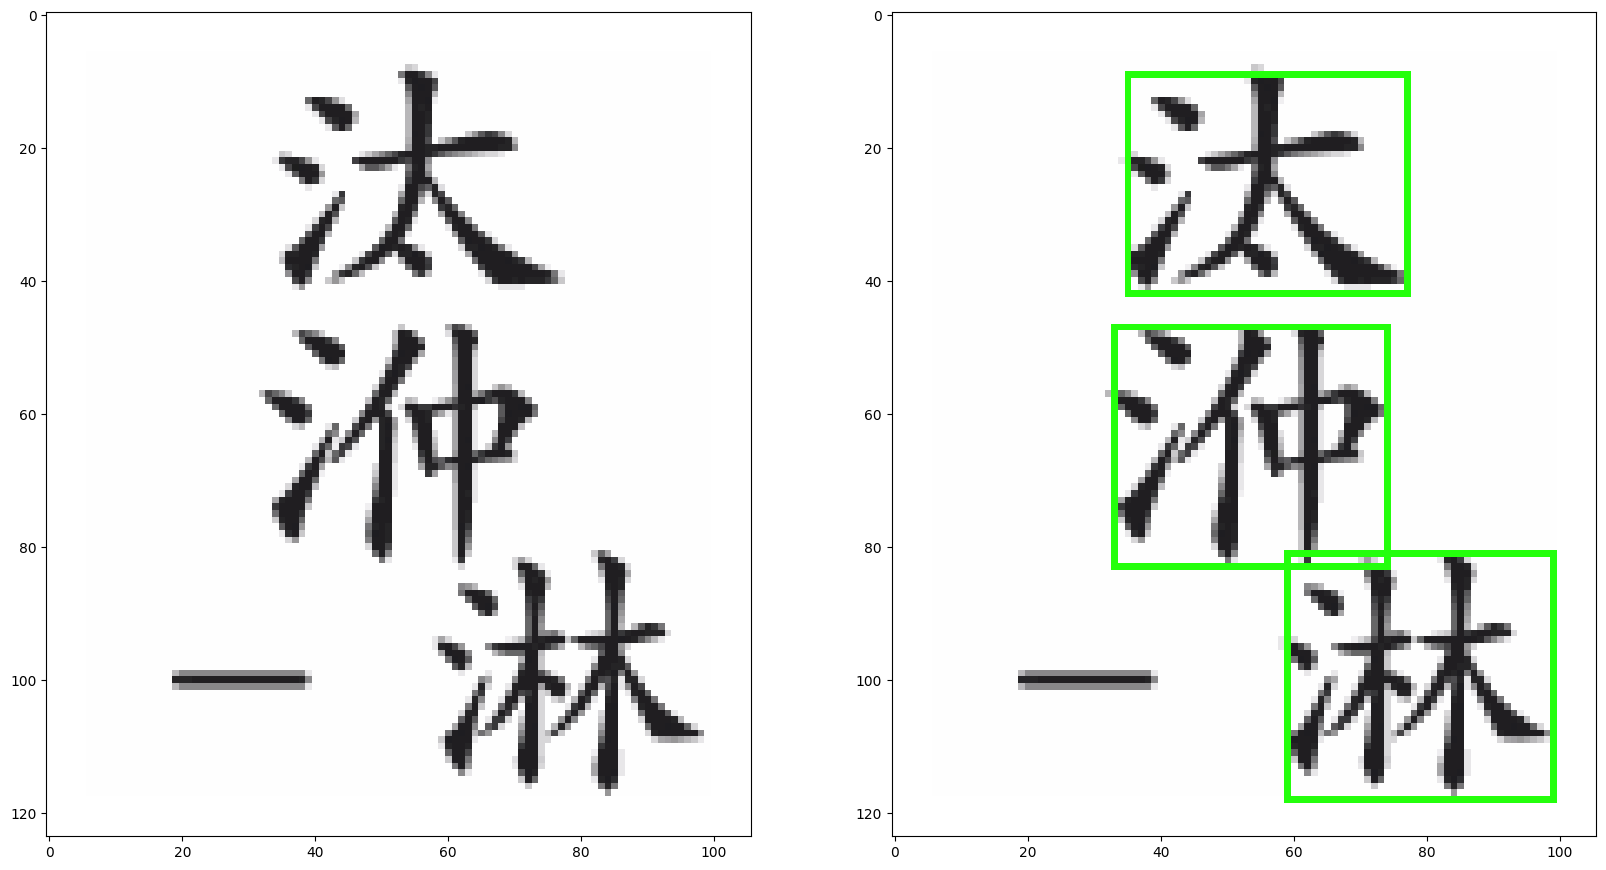

In [107]:
target_jng_idx = 24 # 286

def extract_char_bbox(img):
  bbox_list = []
  bbox_total = 0

  for ptrn_key, ptrn_img in PTRN_IMG_DICT.items():
    xCords, yCords, match_result = jng_matcher.match(img, ptrn_img)
    bboxs_w_confi = [(x, y, match_result[y][x]) for x, y in zip(xCords, yCords)]
    bboxs_merged_w_confi = jng_matcher.merge_bboxs(bboxs_w_confi)
    
    bbox_total += len(bboxs_merged_w_confi) # for debugging
    
    if(len(bboxs_merged_w_confi) > 0):
      bbox_list += [bbox + (ptrn_key,) for bbox in bboxs_merged_w_confi]

  bbox_groups = jng_matcher.group_bboxs(bbox_list, min_ratio=0.6)

  char_bboxs = []

  for bbox_group in bbox_groups:
    slice_tl_x, slice_tl_y, slice_br_x, slice_br_y = jng_matcher.get_bbox_of_bbox_group(bbox_group, img)
    img_sliced = img.copy()[slice_tl_y:slice_br_y, slice_tl_x:slice_br_x]
    
    char_bbox_sliced, *_ = jng_matcher.find_contour_bbox(img_sliced)
    
    char_bbox = tuple([ el + slice_tl_x if idx%2 == 0 else el + slice_tl_y for idx, el in enumerate(char_bbox_sliced) ])
    
    char_bboxs.append(char_bbox)
  
  return char_bboxs

jng_img = jng_matcher.remove_border_add_padding( target_jng_list[target_jng_idx][0] )

jng_char_bboxs = extract_char_bbox(jng_img)

jng_img_char_bboxs = jng_img.copy()

for idx, box in enumerate(jng_char_bboxs):
  tl_x, tl_y, br_x, br_y, *_  = box
  
  cv2.rectangle(jng_img_char_bboxs, (tl_x, tl_y), (br_x, br_y), (36,255,12), 1)

plt.figure(figsize=(20, 20))

plt.subplot(1, 2, 1)
plt.imshow(jng_img)

plt.subplot(1, 2, 2)
plt.imshow(jng_img_char_bboxs)

## full logic test

20 th jng


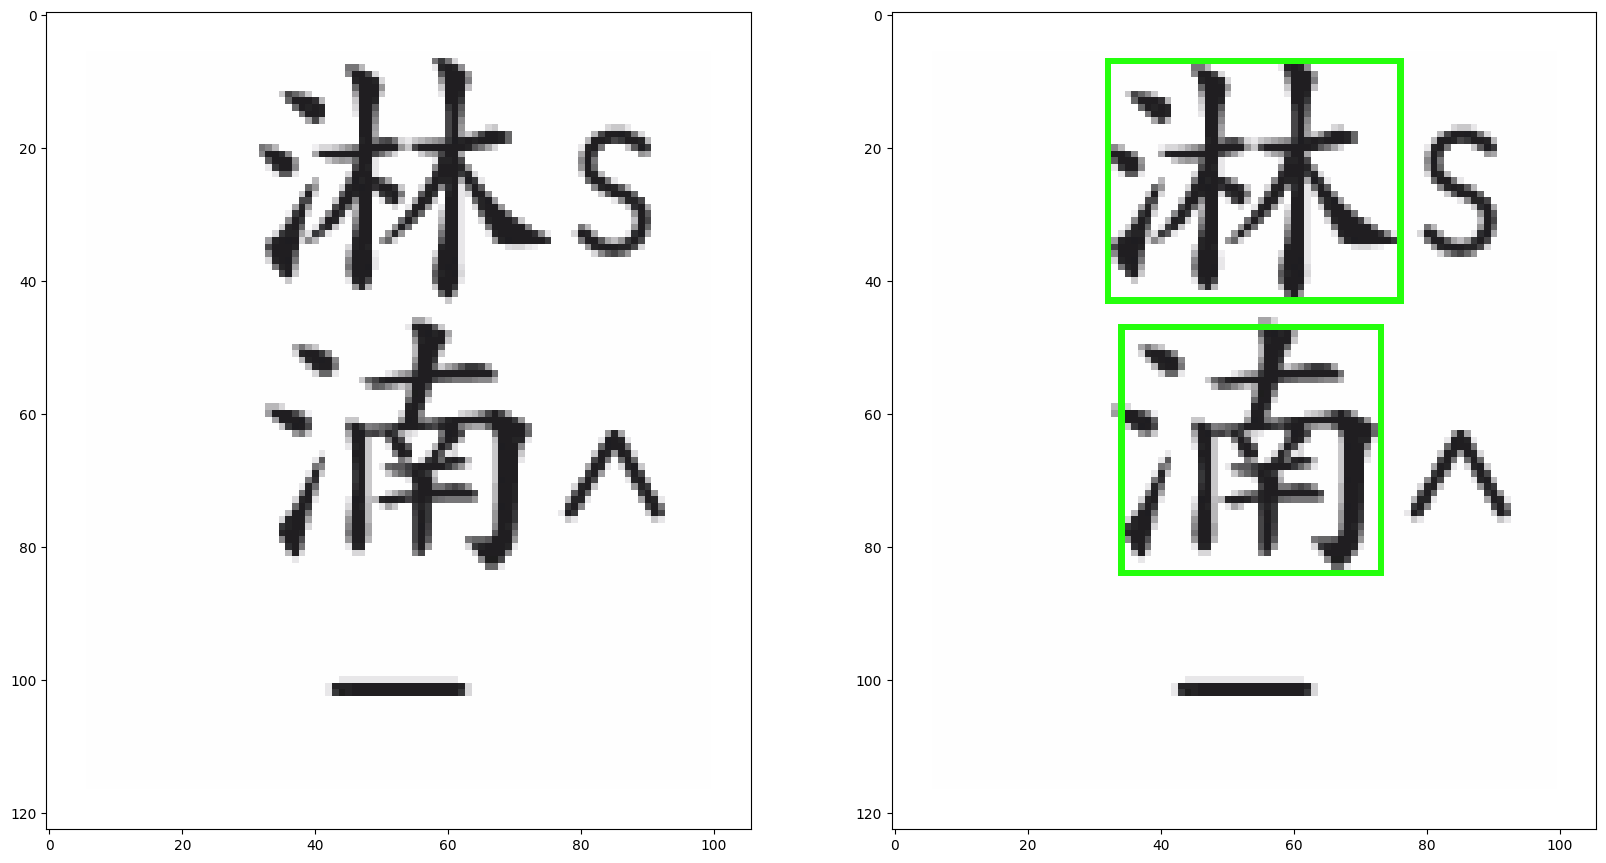

24 th jng


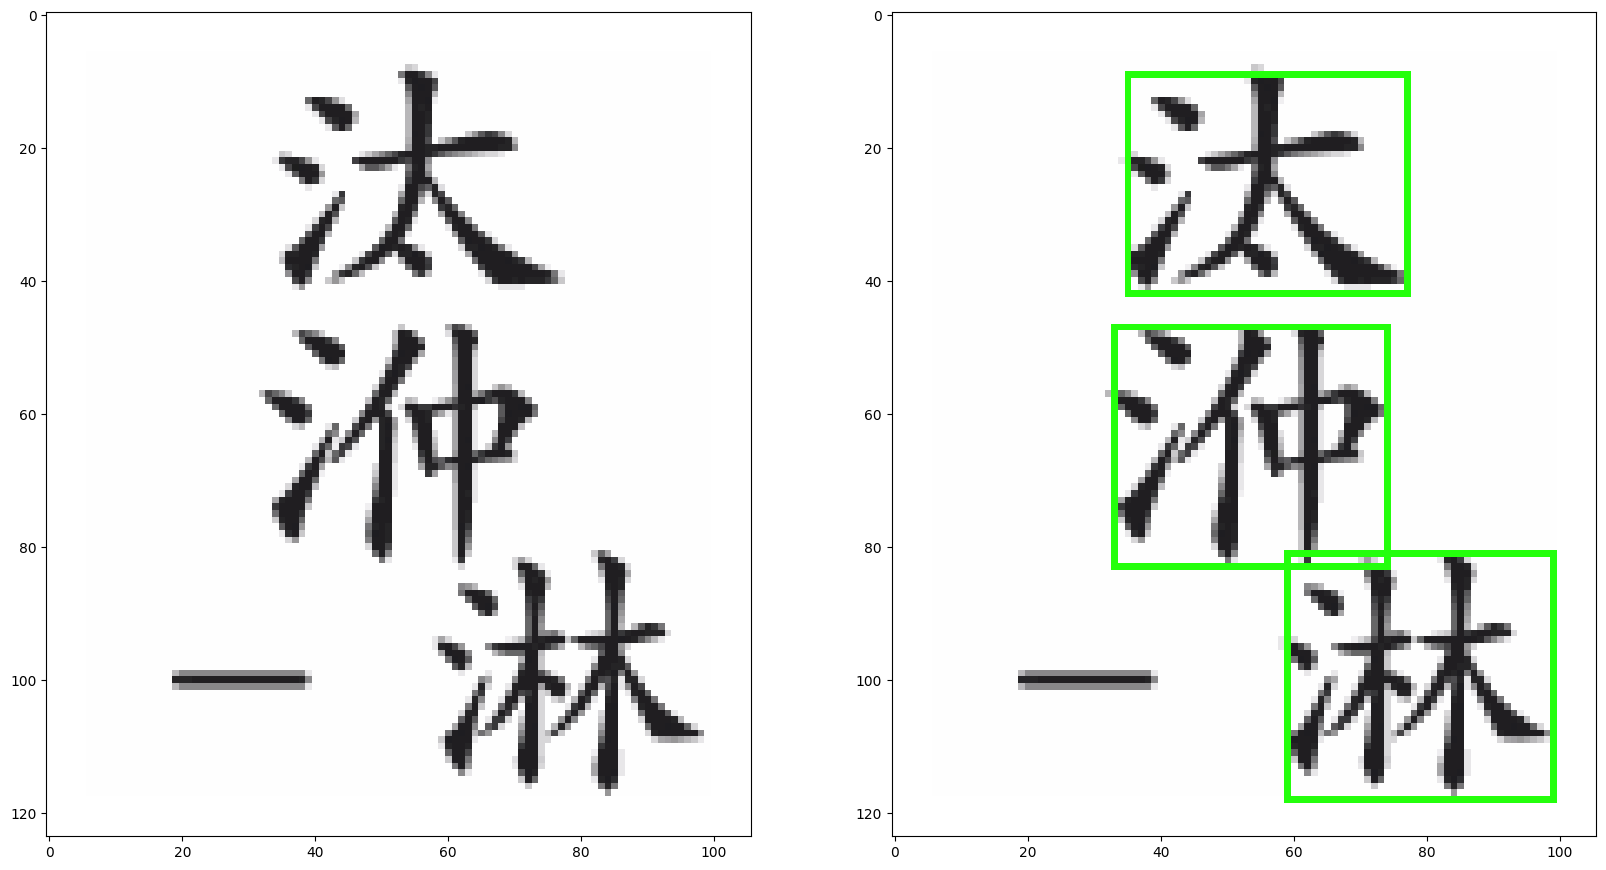

43 th jng


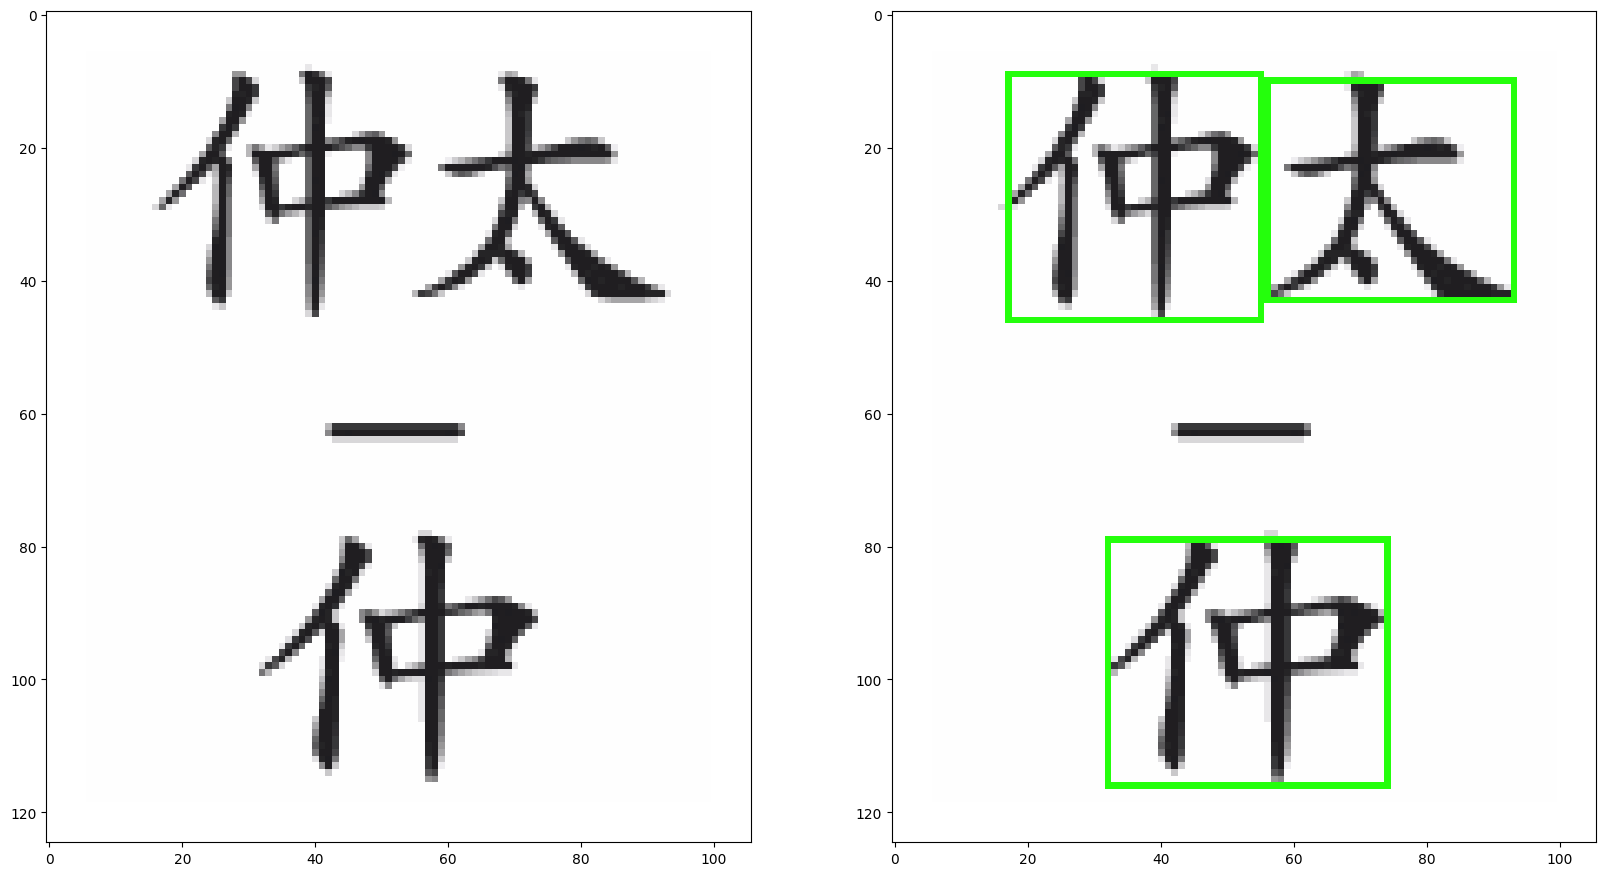

72 th jng


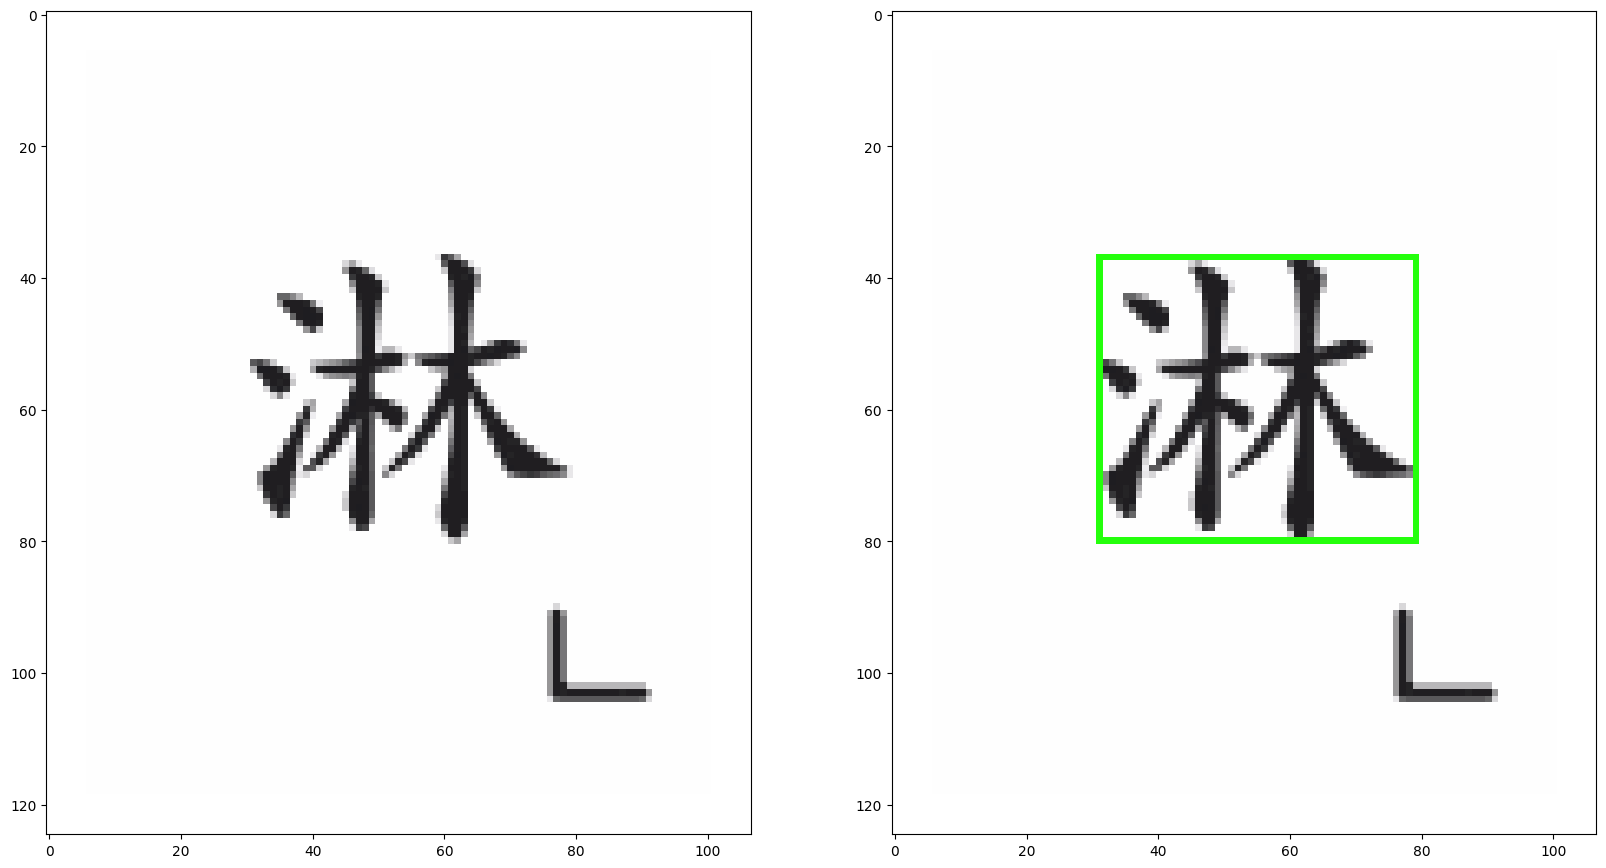

87 th jng


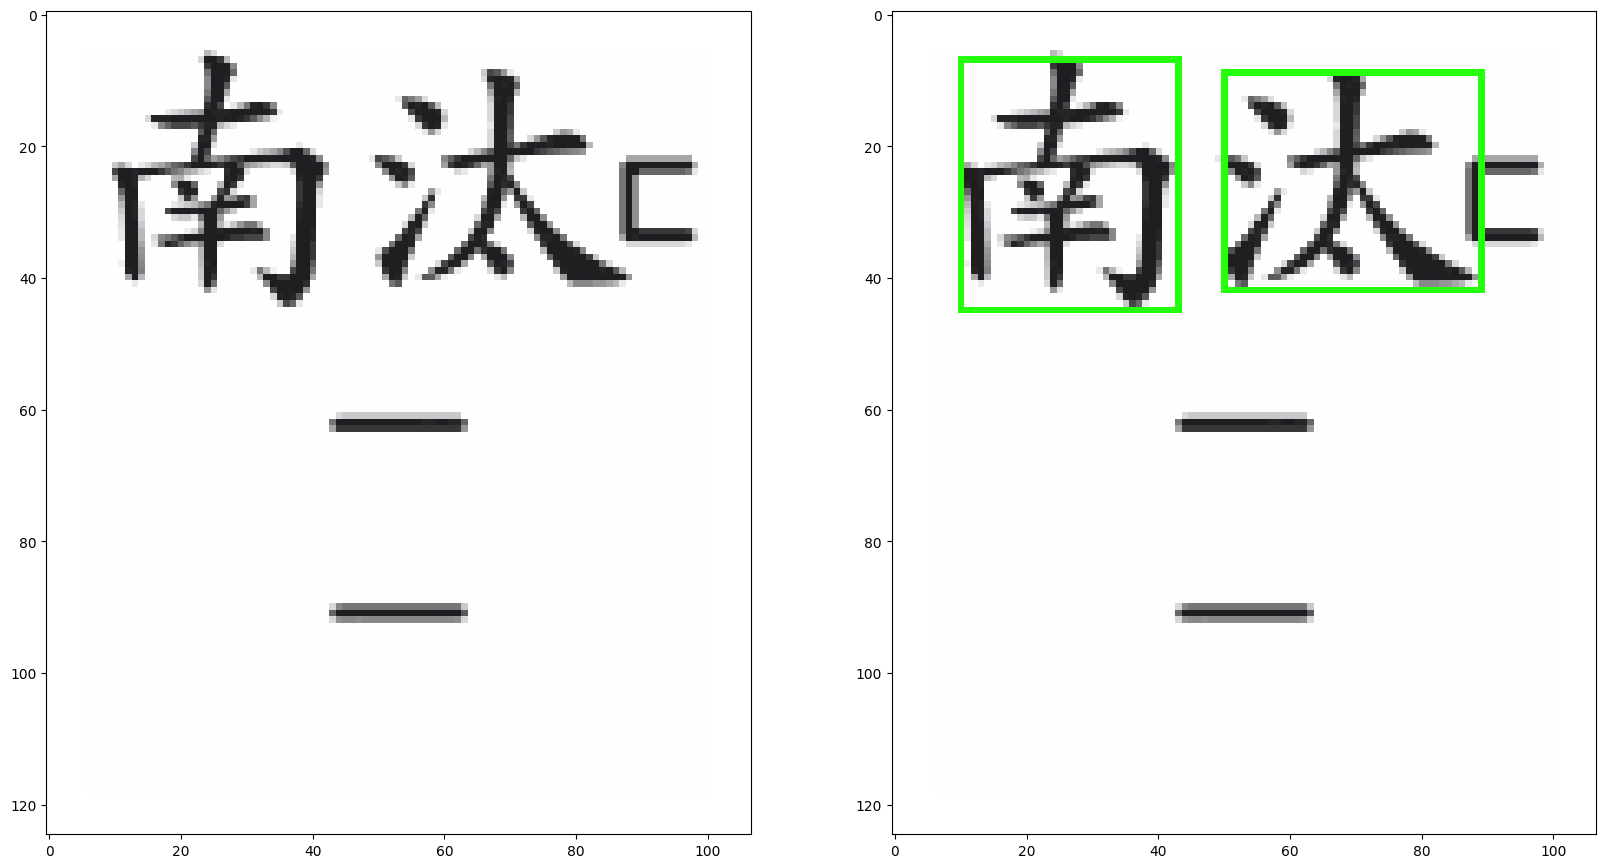

134 th jng


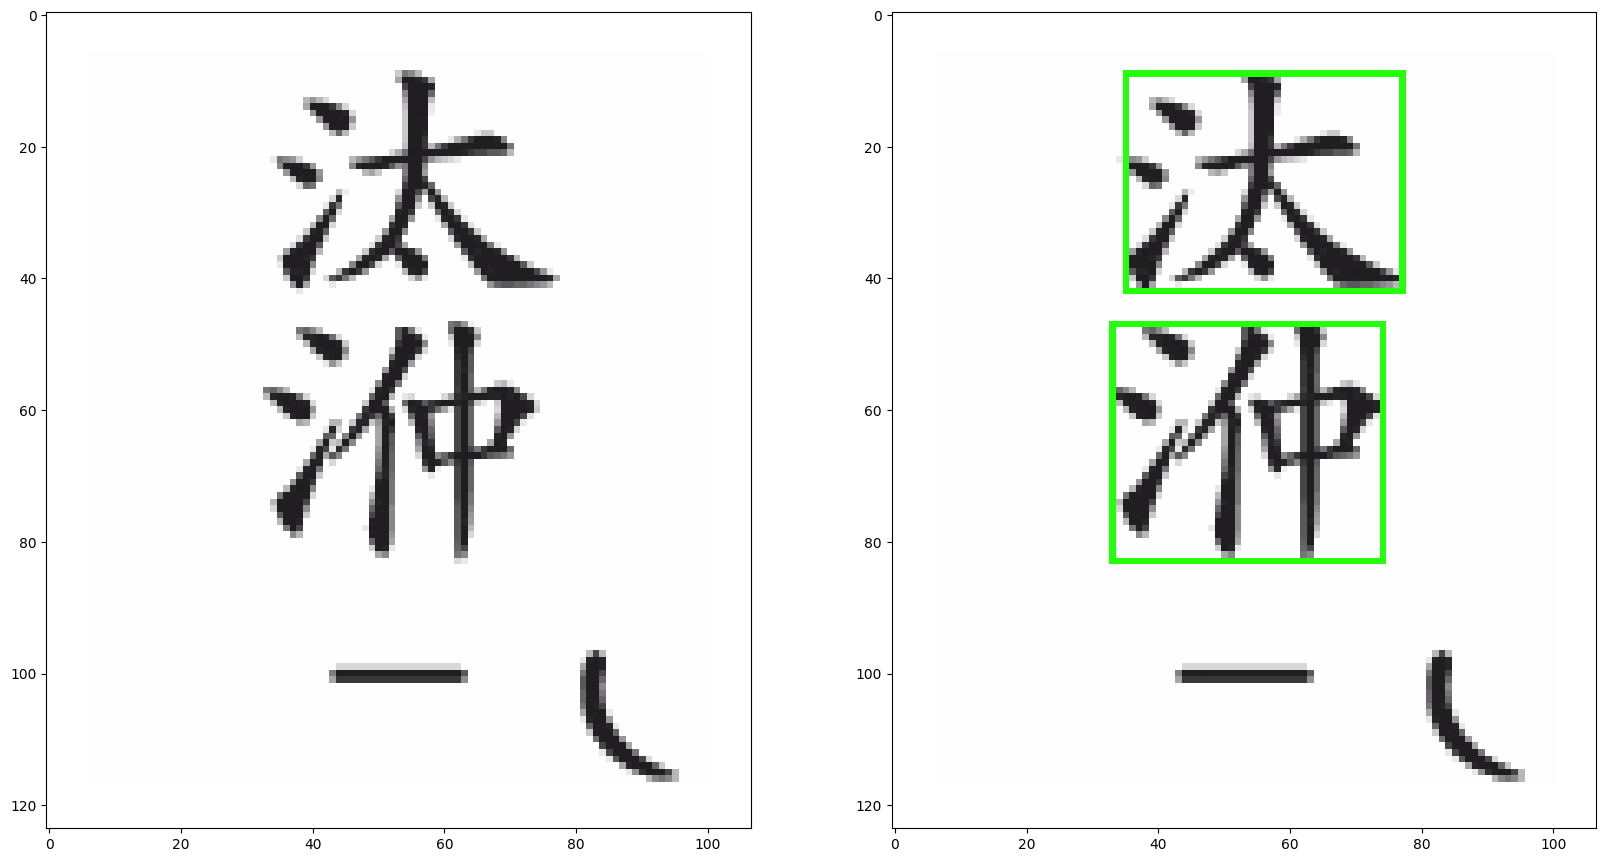

135 th jng


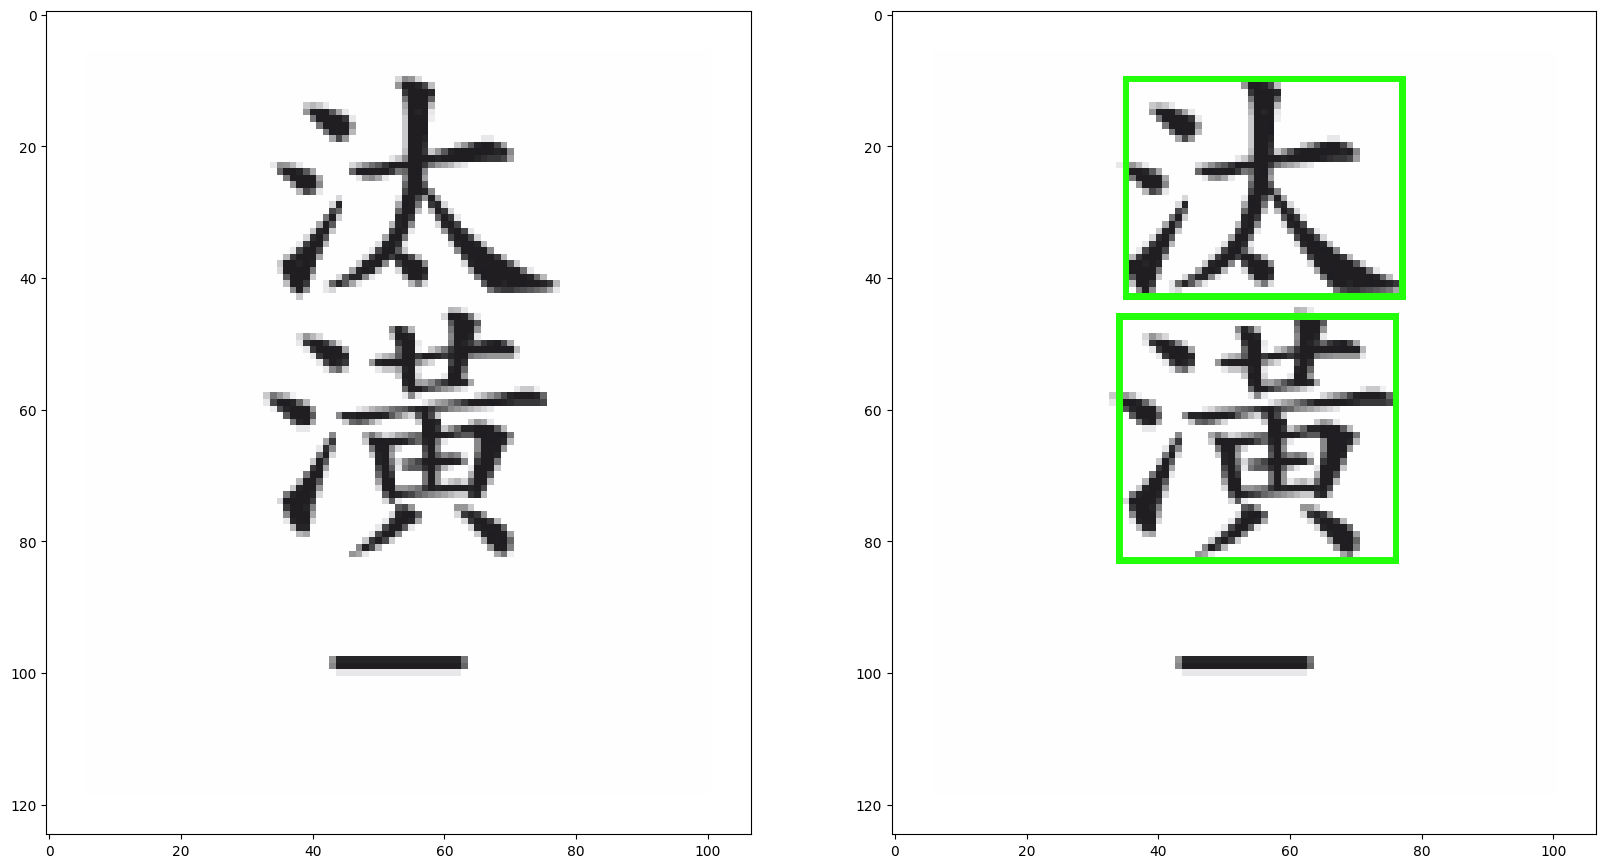

161 th jng


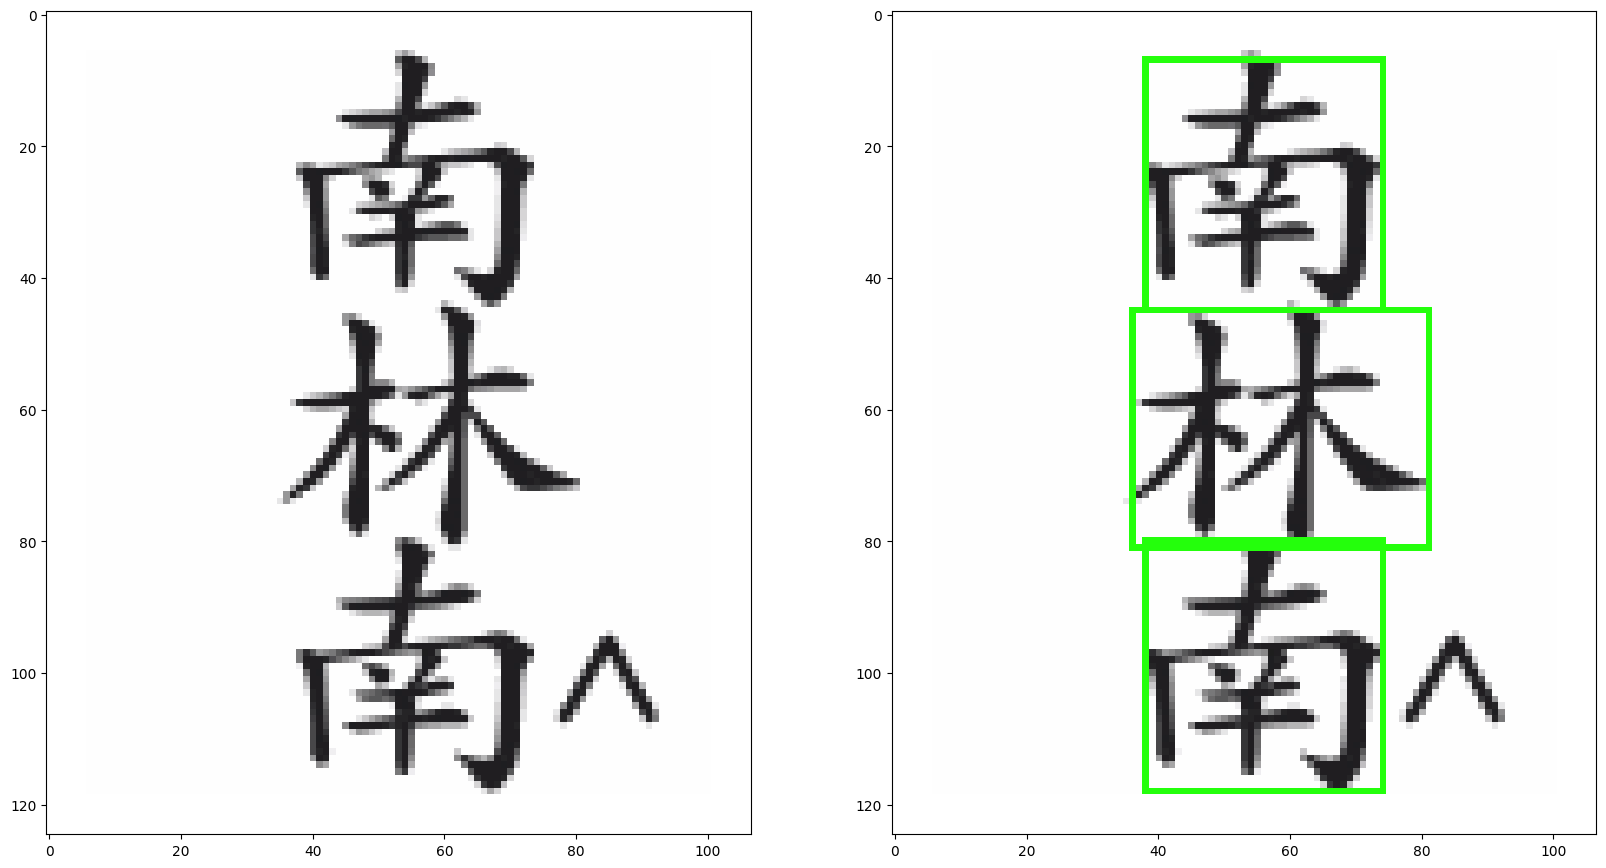

167 th jng


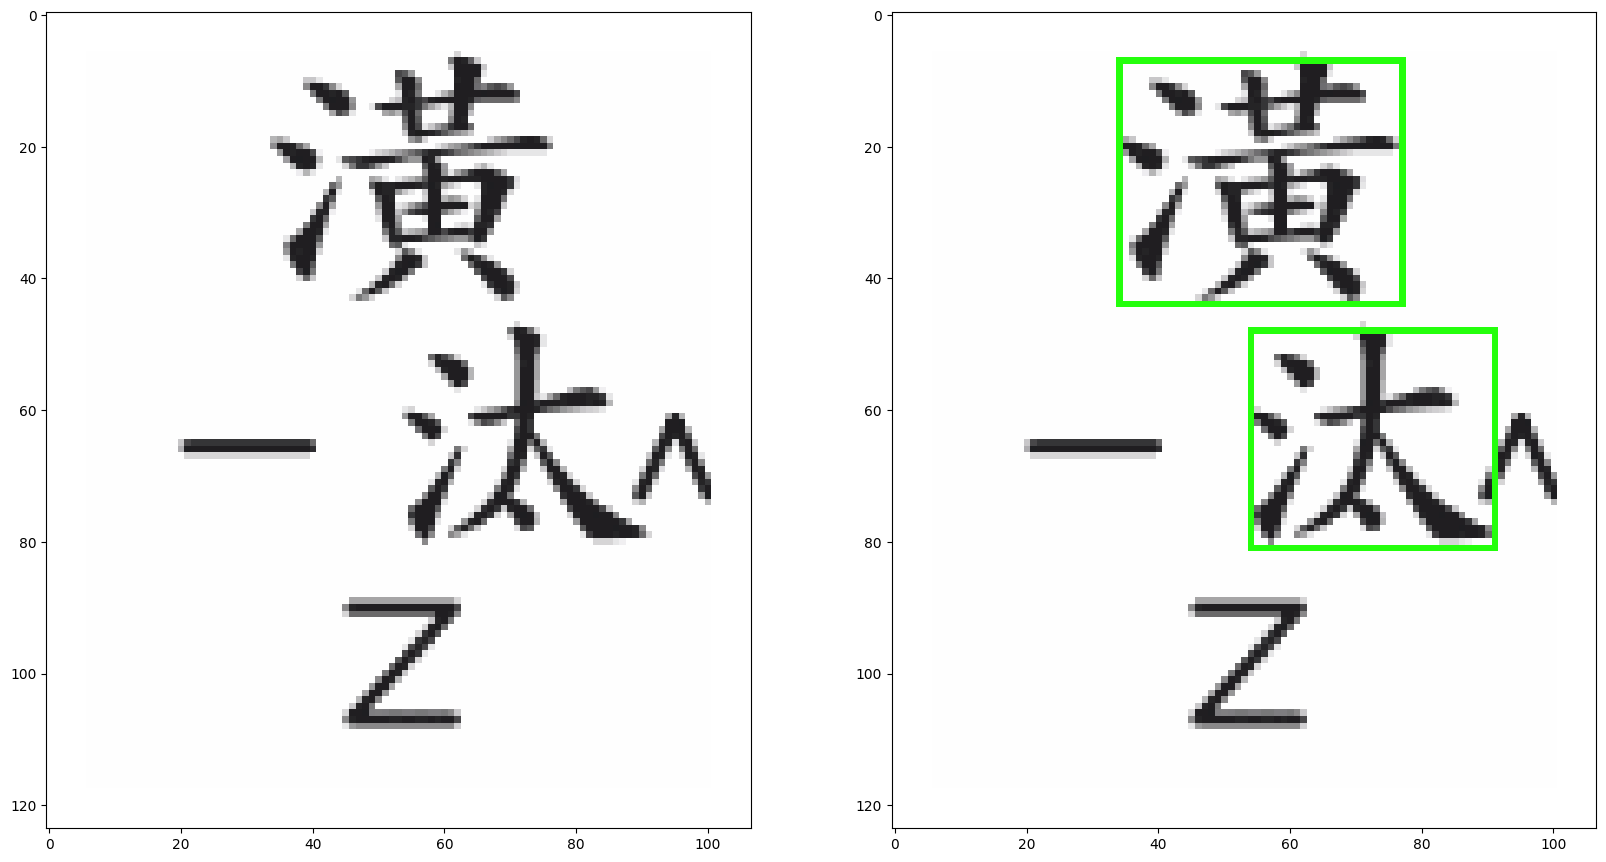

286 th jng


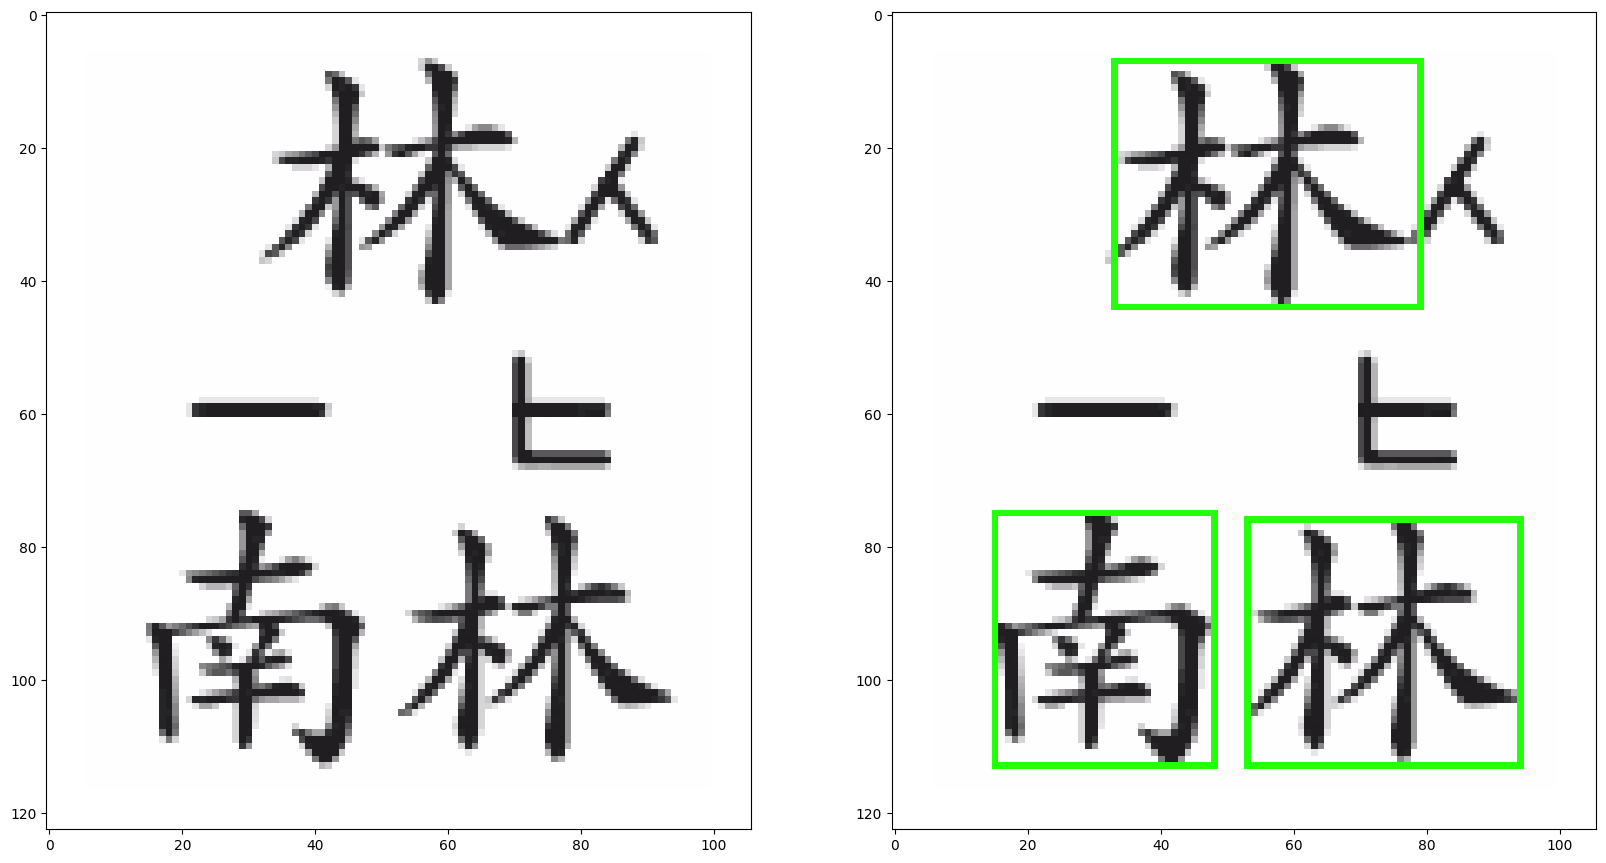

289 th jng


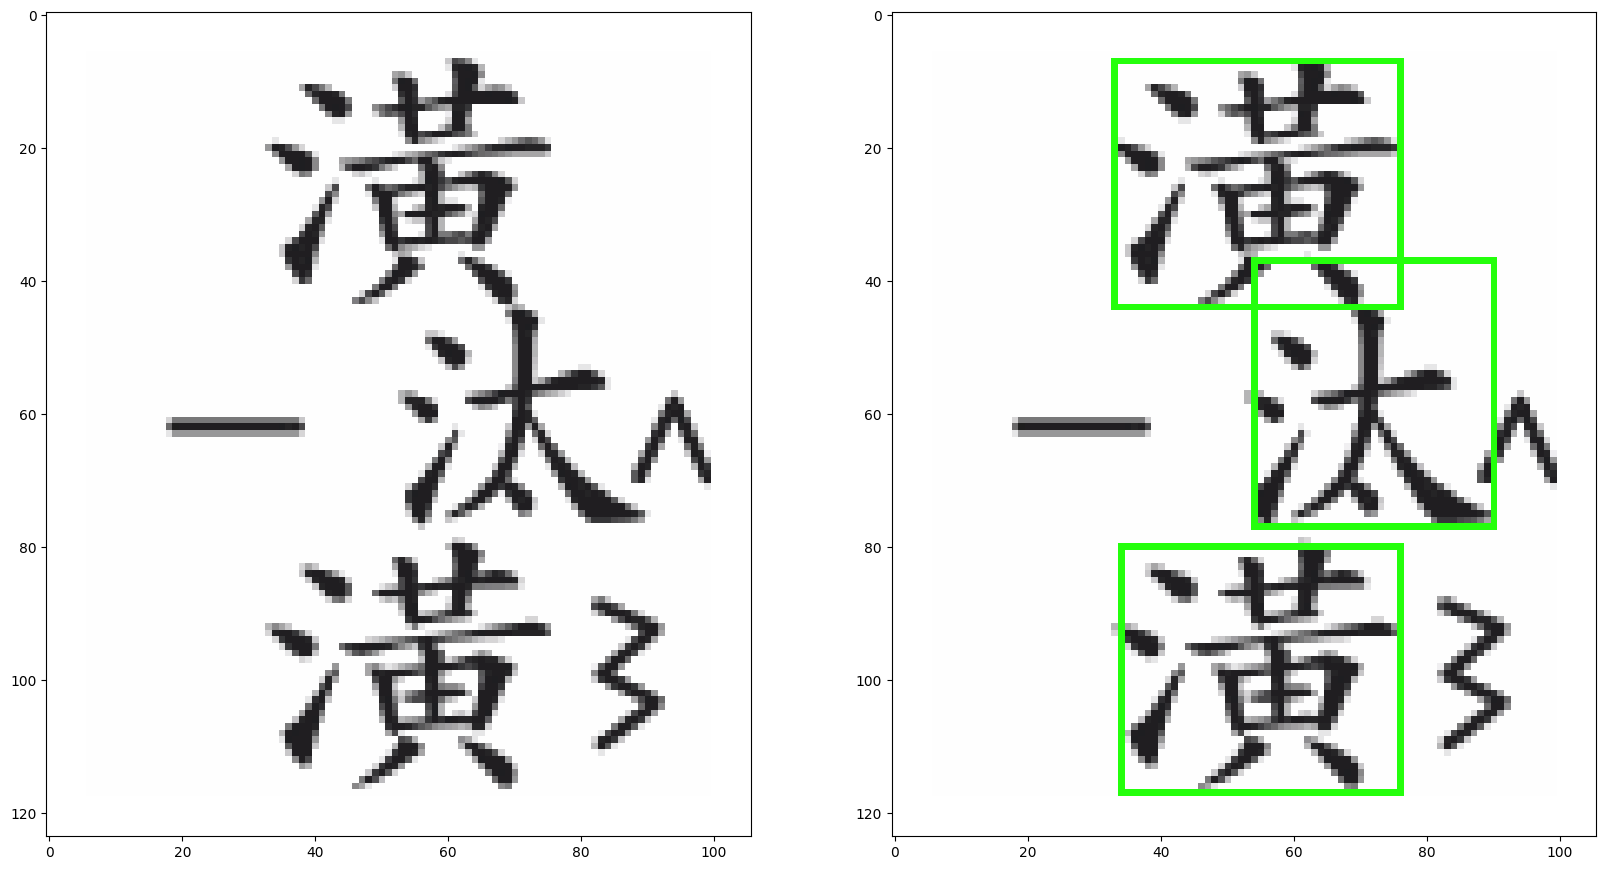

In [126]:
test_jng_idxs = [20, 24, 43, 72, 87, 134, 135, 161, 167, 286, 289]

for jng_idx in test_jng_idxs:

  jng_img = jng_matcher.remove_border_add_padding( target_jng_list[jng_idx][0] )

  jng_char_bboxs = extract_char_bbox(jng_img)

  jng_img_char_bboxs = jng_img.copy()
  
  print(f'{jng_idx} th jng')

  for idx, box in enumerate(jng_char_bboxs):
    tl_x, tl_y, br_x, br_y, *_  = box
    
    cv2.rectangle(jng_img_char_bboxs, (tl_x, tl_y), (br_x, br_y), (36,255,12), 1)

  plt.figure(figsize=(20, 20))

  plt.subplot(1, 2, 1)
  plt.imshow(jng_img)

  plt.subplot(1, 2, 2)
  plt.imshow(jng_img_char_bboxs)
  
  plt.show()

# extracting relative position

## grouping by y position

20 th jng


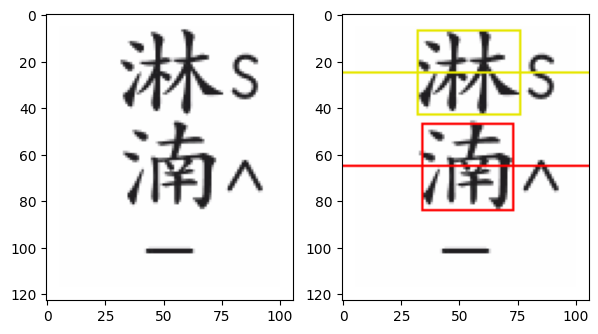

24 th jng


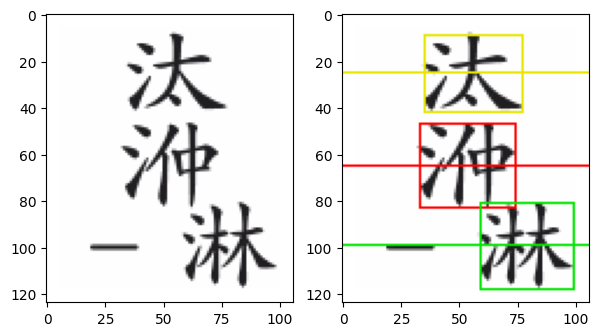

43 th jng


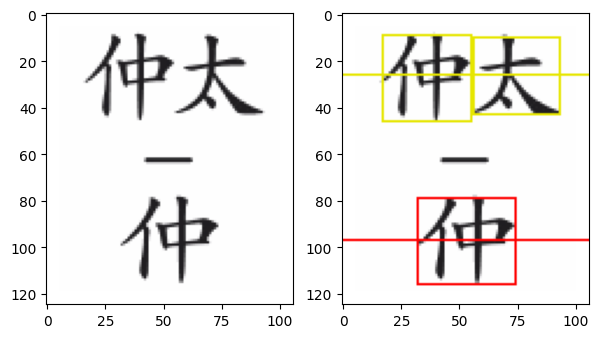

72 th jng


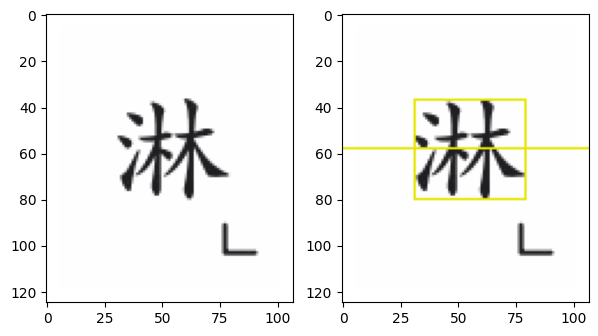

87 th jng


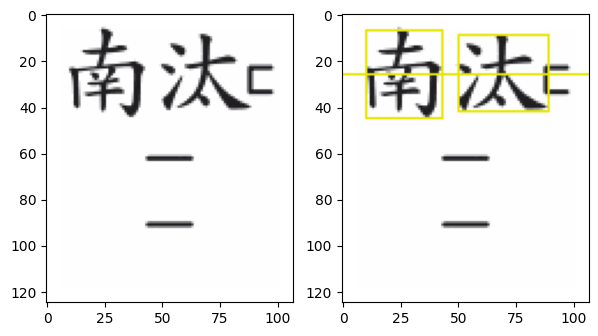

134 th jng


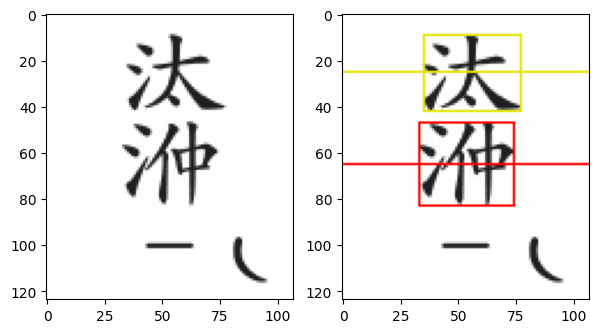

135 th jng


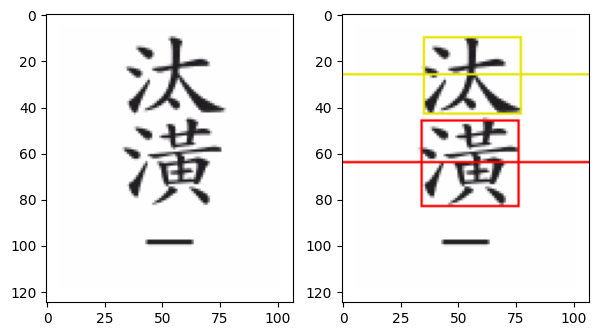

161 th jng


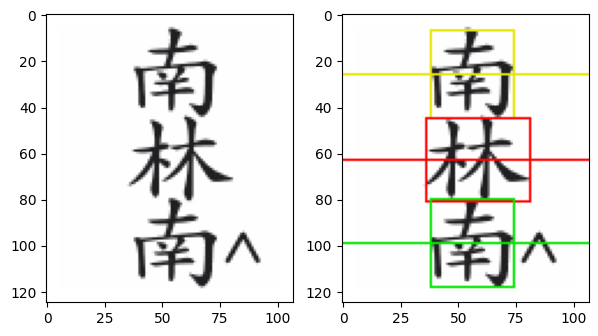

167 th jng


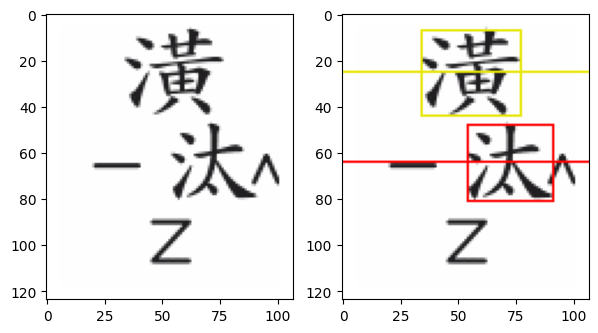

286 th jng


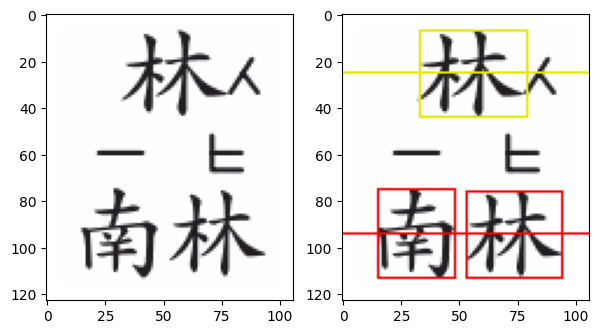

289 th jng


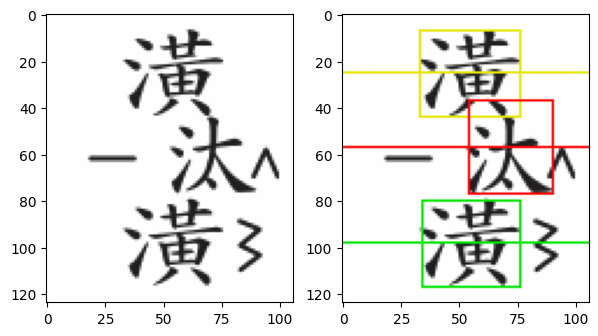

In [178]:
test_jng_idxs = [20, 24, 43, 72, 87, 134, 135, 161, 167, 286, 289]
color_list = [ color for key, color in list( filter( lambda el: '_d' not in el[0] and '_u' not in el[0], COLOR_DICT.items() ) ) ]

def get_center_y(box):
  _, tl_y, _, br_y, *_ = box
  return tl_y + (br_y - tl_y)//2

def is_approximate(target, compare, max_dist=5):  
  t_center_y = get_center_y(target)
  c_center_y = get_center_y(compare)
  
  return abs(t_center_y - c_center_y) < max_dist

def get_y_approximates(boxs, target_box, target_idx, max_dist=5):
  approxs = []
  for idx, box in enumerate(boxs):
    if idx > target_idx and is_approximate(target_box, box, max_dist):
      approxs.append( (box, idx) )
  return approxs

def group_by_ypos(bboxs, max_dist=5):
  bboxs = sorted(bboxs, key=lambda b: b[1])

  bbox_groups = []
  index = 0

  while True:
    if index > len(bboxs) - 1:
      break
    
    curr = bboxs[index]

    # overlapping box indexs
    approxs = get_y_approximates(bboxs, curr, index, max_dist=max_dist)

    if len(approxs) > 0:
      approx_boxs = [ tup[0] for tup in approxs ]
      approx_boxs = [curr] + approx_boxs
      
      bbox_groups.append( approx_boxs )
      
      # remove approxs
      approx_indices = [ tup[1] for tup in approxs ]
      
      approx_indices.sort(reverse=True)
      for approx_idx in approx_indices:
        assert approx_idx < len(bboxs), f'index out of range: {approx_idx} / {len(bboxs) - 1}' 
        del bboxs[approx_idx]
        
    else:
      bbox_groups.append( [curr] )

    index += 1

  return bbox_groups

def get_group_center_y(bbox_group):
  bbox_center_ys = [ get_center_y(bbox) for bbox in bbox_group]
  return round(np.mean(bbox_center_ys))
  

for iter_idx, jng_idx in enumerate(test_jng_idxs):
  jng_img = jng_matcher.remove_border_add_padding( target_jng_list[jng_idx][0] )

  jng_char_bboxs = extract_char_bbox(jng_img)
  jng_char_bbox_groups = group_by_ypos(jng_char_bboxs, max_dist=5)
  
  print(f'{jng_idx} th jng')

  jng_img_char_bboxs = jng_img.copy()

  for idx, group in enumerate(jng_char_bbox_groups):
    color = color_list[idx]
    
    center_y = get_group_center_y(group)
    cv2.line(jng_img_char_bboxs, (0, center_y), (jng_img.shape[1], center_y), color, 1)
    
    for box in group:
      tl_x, tl_y, br_x, br_y, *_  = box  
      cv2.rectangle(jng_img_char_bboxs, (tl_x, tl_y), (br_x, br_y), color, 1)

  plt.figure(figsize=(7, 7))

  plt.subplot(1, 2, 1)
  plt.imshow(jng_img)

  plt.subplot(1, 2, 2)
  plt.imshow(jng_img_char_bboxs)
  
  plt.show()

## quantize to row template
* **jng dim average**
    * height: 120 (119.7375)
    * width: 104 (103.63125)

20 th jng
[25, 65]


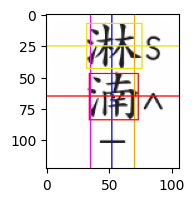

24 th jng
[25, 65, 99]


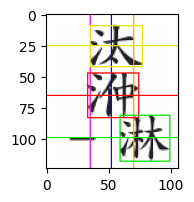

43 th jng
[26, 97]


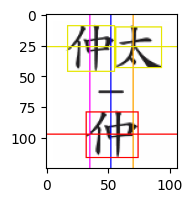

72 th jng
[58]


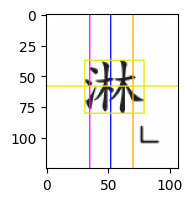

87 th jng
[26]


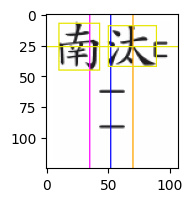

134 th jng
[25, 65]


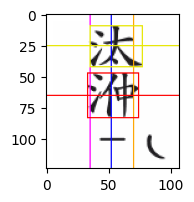

135 th jng
[26, 64]


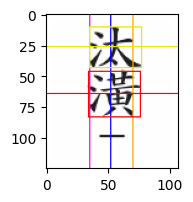

161 th jng
[26, 63, 99]


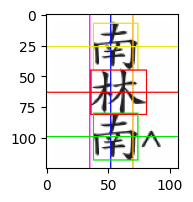

167 th jng
[25, 64]


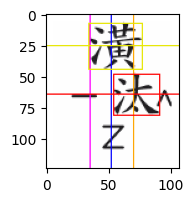

286 th jng
[25, 94]


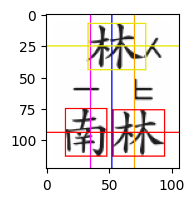

289 th jng
[25, 57, 98]


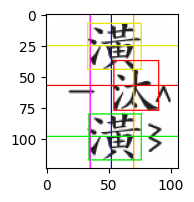

In [183]:
# row templates
row_template = [
  (60, ),
  (40, 80),
  (30, 60, 90)
]

col_template = (35, 52, 70)

test_jng_idxs = [20, 24, 43, 72, 87, 134, 135, 161, 167, 286, 289]
color_list = [ color for key, color in list( filter( lambda el: '_d' not in el[0] and '_u' not in el[0], COLOR_DICT.items() ) ) ]

for iter_idx, jng_idx in enumerate(test_jng_idxs):
  jng_img = jng_matcher.remove_border_add_padding( target_jng_list[jng_idx][0] )

  jng_char_bboxs = extract_char_bbox(jng_img)
  jng_char_bbox_groups = group_by_ypos(jng_char_bboxs, max_dist=5)
  jng_char_rows = [ get_group_center_y(group) for group in jng_char_bbox_groups ]
  
  print(f'{jng_idx} th jng')
  print(jng_char_rows)

  jng_img_char_bboxs = jng_img.copy()
  
  for col_idx, col_x in enumerate(col_template):
    color = color_list[col_idx + 3]
    cv2.line(jng_img_char_bboxs, (col_x, 0), (col_x, jng_img.shape[0]), color, 1)

  for idx, group in enumerate(jng_char_bbox_groups):
    color = color_list[idx]
    
    center_y = get_group_center_y(group)
    cv2.line(jng_img_char_bboxs, (0, center_y), (jng_img.shape[1], center_y), color, 1)
    
    for box in group:
      tl_x, tl_y, br_x, br_y, *_  = box  
      cv2.rectangle(jng_img_char_bboxs, (tl_x, tl_y), (br_x, br_y), color, 1)

  plt.figure(figsize=(2, 2))

  # plt.subplot(1, 2, 1)
  # plt.imshow(jng_img)

  # plt.subplot(1, 2, 2)
  plt.imshow(jng_img_char_bboxs)
  
  plt.show()